In [21]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

end_month = 202412

In [22]:
char = pd.read_feather('/home/yuanzhi/research_data/chars_data/chars60_raw_no_impute.feather')
char.shape

(3028230, 73)

### 1. Use All-Stocks value-weighted to calculate EP, DY, LEV, NI, BM

In [23]:
def vw(df,w,c,g):
    df['wc']=df[w]*df[c]
    tmp = df.groupby(g)['wc'].sum()/df.groupby(g)[w].sum()
    del df['wc']
    return tmp

lev = vw(char,'me','lev',['date'])*1000 # Leverage (LEV)
ep = vw(char,'me','ep',['date'])*1000 # Earnings-to-Price (EP)
dy = vw(char,'me','dy',['date'])*1000 # Dividend Yield (DY)
ni = vw(char,'me','ni',['date'])*1000 # Net Equity Issues (NI)
bm = vw(char,'me','bm',['date'])*1000 # Book-to-Market (BM)

mktvars = pd.DataFrame([dy,lev,ep,ni,bm]).T
mktvars.columns = ['x_dy','x_lev','x_ep','x_ni','x_bm']
mktvars = mktvars.reset_index()
mktvars['date'] = pd.to_datetime(mktvars['date'], format='%Y-%m-%d')

In [24]:
mktvars

,date,x_dy,x_lev,x_ep,x_ni,x_bm
0,1950-11-30,53.190756,289.257530,112.445791,0.000000,0.000000
1,1950-12-31,54.374423,446.475915,115.804228,0.000000,0.000000
2,1951-01-31,52.092585,361.223544,130.647586,0.000000,0.000000
3,1951-02-28,55.719601,384.884595,135.209717,0.000000,0.000000
4,1951-03-31,61.284207,407.650065,141.634240,0.000000,0.000000
...,...,...,...,...,...,...
885,2024-08-31,12.251714,841.078644,32.810354,-3.079321,235.522375
886,2024-09-30,12.025295,825.949613,32.302570,-3.245314,231.332563
887,2024-10-31,11.791691,809.306316,31.785911,-3.021149,226.658521
888,2024-11-30,11.934402,807.522342,31.626092,-2.023189,230.343436


### 2. Use 12-months rolling-window mktrf variance to calculate SVAR

In [25]:
# df_mktrf = pd.read_csv('FF3.csv')
# df_mktrf['MKT'] = df_mktrf['MKTRF'] + df_mktrf['RF']
# df_mktrf.iloc[:, 1:] = df_mktrf.iloc[:, 1:] / 100
# df_mktrf['year'] = df_mktrf['Date'].apply(lambda x: str(x)[0:4])
# df_mktrf['month'] = df_mktrf['Date'].apply(lambda x: str(x)[4:6])
# df_mktrf['day'] = 1
# df_mktrf['date'] = pd.to_datetime(df_mktrf[['year', 'month', 'day']]) + MonthEnd(0)

# calc_svar = []
# for i in range(df_mktrf.shape[0]):
#     if i < 250:
#         calc_svar.append(np.nan)
#     else:
#         temp_df = df_mktrf.iloc[i-250:i, :]
#         calc_svar.append(np.var(temp_df['MKT']))

# df_mktrf['svar'] = calc_svar
# df_mktrf = df_mktrf.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
# df_mktrf = df_mktrf[['date', 'svar']]
# df_mktrf = df_mktrf.drop_duplicates(subset=['date'], keep='last').reset_index(drop=True)

In [26]:
# Stock Variance (SVAR)
dates_filepath = 'FF3.csv'
df_mktrf = pd.read_csv("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip", header=3, index_col=0)
df_mktrf = df_mktrf.reset_index().loc[:(df_mktrf.index.tolist().index(df_mktrf.index.tolist()[-1]) - 1)]
df_mktrf = df_mktrf.rename(columns={'index': 'Date', 'Mkt-RF':'MKTRF'})
# df_mktrf.to_csv(dates_filepath, index=False, encoding="utf_8_sig")

df_mktrf['MKT'] = df_mktrf['MKTRF'] + df_mktrf['RF']
df_mktrf.iloc[:, 1:] = df_mktrf.iloc[:, 1:].astype("float") / 100
df_mktrf['year'] = df_mktrf['Date'].apply(lambda x: str(x)[0:4])
df_mktrf['month'] = df_mktrf['Date'].apply(lambda x: str(x)[4:6])
df_mktrf['day'] = 1
df_mktrf['date'] = pd.to_datetime(df_mktrf[['year', 'month', 'day']]) + MonthEnd(0)

month_list = sorted(list(set(df_mktrf['date'])))
frame_svar = []
for month in month_list:
    temp_df = df_mktrf[(df_mktrf.date > month-relativedelta(months=12)) & (df_mktrf.date <= month)]
    frame_svar.append(pd.DataFrame([[month, np.var(temp_df['MKT'])]], columns=['date', 'svar']))
df_mktrf = pd.concat(frame_svar).reset_index(drop=True)

# Merge with previous data
df_xt = mktvars.merge(df_mktrf, on=['date'], how='left')
df_xt.rename(columns={'svar':'x_svar'}, inplace=True)

In [27]:
df_mktrf

,date,svar
0,1926-07-31,0.000019
1,1926-08-31,0.000027
2,1926-09-30,0.000026
3,1926-10-31,0.000037
4,1926-11-30,0.000033
...,...,...
1186,2025-05-31,0.000166
1187,2025-06-30,0.000167
1188,2025-07-31,0.000162
1189,2025-08-31,0.000154


### 3. Obtain Illiquidity and Liquidity data from 
- https://finance.wharton.upenn.edu/~stambaug/liq_data_1962_2023.txt \
--- Column 2: Levels of aggregated liquidity (Figure 1 in the paper)

In [28]:
# Illiquidity (Ill)
dates_filepath = 'liquidity.csv'
ill = pd.read_csv("https://finance.wharton.upenn.edu/~stambaug/liq_data_1962_2024.txt", header=10, index_col=0).reset_index()
ill = ill[ill.columns[0]].str.split('\t', expand=True)
ill.columns = ['Month', 'x_ill', 'Innov Liq (eq8)', 'LIQ', 'Other']
ill = ill[['Month', 'x_ill']]
# ill.to_csv(dates_filepath)

ill['year'] = ill['Month'].apply(lambda x: str(x)[0:4])
ill['month'] = ill['Month'].apply(lambda x: str(x)[4:6])
ill['day'] = 1
ill['date'] = pd.to_datetime(ill[['year', 'month', 'day']]) + MonthEnd(0)
ill = ill[['date', 'x_ill']]

df_xt = df_xt.merge(ill, on=['date'], how='left')

# Liquidity (Liq)
df_xt['x_liq'] = df_xt['x_ill'].rolling(12, min_periods=1).mean().fillna(0)

In [29]:
df_xt.head(120)

,date,x_dy,x_lev,x_ep,x_ni,x_bm,x_svar,x_ill,x_liq
0,1950-11-30,53.190756,289.257530,112.445791,0.000000,0.000000,0.000056,NaN,0.0
1,1950-12-31,54.374423,446.475915,115.804228,0.000000,0.000000,0.000063,NaN,0.0
2,1951-01-31,52.092585,361.223544,130.647586,0.000000,0.000000,0.000064,NaN,0.0
3,1951-02-28,55.719601,384.884595,135.209717,0.000000,0.000000,0.000065,NaN,0.0
4,1951-03-31,61.284207,407.650065,141.634240,0.000000,0.000000,0.000068,NaN,0.0
...,...,...,...,...,...,...,...,...,...
115,1960-06-30,33.943540,262.137068,59.927470,21.041929,0.766324,0.000035,NaN,0.0
116,1960-07-31,33.319848,257.164230,58.790639,20.597485,0.751517,0.000037,NaN,0.0
117,1960-08-31,34.126621,265.807047,60.269427,20.561746,0.770403,0.000035,NaN,0.0
118,1960-09-30,33.274249,259.088299,58.804214,20.564550,0.749866,0.000035,NaN,0.0


### 4. Obtain inflation, TBL, DFY, TMS from FRED

In [30]:
#Inflation (INFL)
df_cpi = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1947-01-01&coed=2025-09-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-16&revision_date=2025-11-16&nd=1947-01-01")
df_cpi['date'] = pd.to_datetime(df_cpi[df_cpi.columns[0]]) + MonthEnd(0)
# df_cpi = pd.read_csv("https://fred.stlouisfed.org/series/CPIAUCSL/downloaddata/CPIAUCSL.csv", header=0, index_col=0).reset_index().rename(columns={'VALUE':'CPIAUCSL'})
# df_cpi['date'] = pd.to_datetime(df_cpi['DATE']) + MonthEnd(0)
df_cpi['CPIAUCSL_substract'] = df_cpi['CPIAUCSL'].shift(12)
df_cpi['x_infl'] = (df_cpi['CPIAUCSL'] - df_cpi['CPIAUCSL_substract']) / df_cpi['CPIAUCSL_substract']
df_cpi = df_cpi[['date', 'x_infl']]
df_xt = df_xt.merge(df_cpi, on=['date'], how='left')

# Treasury-Bill Rate (TBL)
df_tbl = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=893&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=TB3MS&scale=left&cosd=1934-01-01&coed=2025-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-16&revision_date=2025-11-16&nd=1934-01-01")
df_tbl['date'] = pd.to_datetime(df_tbl[df_tbl.columns[0]]) + MonthEnd(0)
# df_tbl = pd.read_csv("https://fred.stlouisfed.org/series/TB3MS/downloaddata/TB3MS.csv", header=0, index_col=0).reset_index().rename(columns={'VALUE':'TB3MS'})
# df_tbl['date'] = pd.to_datetime(df_tbl['DATE']) + MonthEnd(0)
df_tbl['x_tbl'] = df_tbl['TB3MS'].astype(float) / 100
df_tbl['TB3MS_shift'] = df_tbl['x_tbl'].shift(1)
df_tbl['x_deltatbl'] = df_tbl['x_tbl'] - df_tbl['TB3MS_shift']
df_xt = df_xt.merge(df_tbl[['date', 'x_tbl', 'x_deltatbl']], on=['date'], how='left')

# Default Yield (DFY)
df_baa = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=BAA&scale=left&cosd=1919-01-01&coed=2025-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-16&revision_date=2025-11-16&nd=1919-01-01")
df_aaa = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=AAA&scale=left&cosd=1919-01-01&coed=2025-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-16&revision_date=2025-11-16&nd=1919-01-01")
df_baa['date'] = pd.to_datetime(df_baa[df_baa.columns[0]]) + MonthEnd(0)
df_aaa['date'] = pd.to_datetime(df_aaa[df_aaa.columns[0]]) + MonthEnd(0)
# df_baa = pd.read_csv("https://fred.stlouisfed.org/series/BAA/downloaddata/BAA.csv", header=0, index_col=0).reset_index().rename(columns={'VALUE':'BAA'})
# df_aaa = pd.read_csv("https://fred.stlouisfed.org/series/AAA/downloaddata/AAA.csv", header=0, index_col=0).reset_index().rename(columns={'VALUE':'AAA'})
# df_bondrate = df_baa.merge(df_aaa, on=['DATE'], how='left')
# df_bondrate['date'] = pd.to_datetime(df_bondrate['DATE']) + MonthEnd(0)
df_bondrate = df_baa.merge(df_aaa, on=['date'], how='left')
df_bondrate['x_dfy'] = (df_bondrate['BAA'] - df_bondrate['AAA']) / 100
df_bondrate = df_bondrate[['date', 'x_dfy']]
df_xt = df_xt.merge(df_bondrate, on=['date'], how='left')

# Term Spread (TMS)
df_lty = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=IRLTLT01USM156N&scale=left&cosd=1953-04-01&coed=2025-09-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-16&revision_date=2025-11-16&nd=1953-04-01")
df_lty['date'] = pd.to_datetime(df_lty[df_lty.columns[0]]) + MonthEnd(0)
# df_lty = pd.read_csv("https://fred.stlouisfed.org/series/IRLTLT01USM156N/downloaddata/IRLTLT01USM156N.csv", header=0, index_col=0).reset_index().rename(columns={'VALUE':'IRLTLT01USM156N'})
# df_lty['date'] = pd.to_datetime(df_lty['DATE']) + MonthEnd(0)
df_lty = df_lty.merge(df_tbl, on=['date'], how='left')
df_lty['x_tms'] = df_lty['IRLTLT01USM156N'] / 100 - df_lty['x_tbl']
df_lty = df_lty[['date', 'x_tms']]
df_xt = df_xt.merge(df_lty, on=['date'], how='left')

In [31]:
# Re-order data
df_xt = df_xt[['date', 'x_ep', 'x_dy', 'x_lev', 'x_ni', 'x_bm', 'x_svar', 'x_ill', 'x_liq', 'x_infl', 'x_tbl', 'x_deltatbl', 'x_dfy', 'x_tms']]
df_xt[['x_svar', 'x_ill', 'x_liq', 'x_infl', 'x_tbl', 'x_deltatbl', 'x_dfy', 'x_tms']] = df_xt[['x_svar', 'x_ill', 'x_liq', 'x_infl', 'x_tbl', 'x_deltatbl', 'x_dfy', 'x_tms']].shift(1)
df_xt

,date,x_ep,x_dy,x_lev,x_ni,x_bm,x_svar,x_ill,x_liq,x_infl,x_tbl,x_deltatbl,x_dfy,x_tms
0,1950-11-30,112.445791,53.190756,289.257530,0.000000,0.000000,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-12-31,115.804228,54.374423,446.475915,0.000000,0.000000,0.000056,None,0.000000,0.037975,0.0136,0.0005,0.0055,NaN
2,1951-01-31,130.647586,52.092585,361.223544,0.000000,0.000000,0.000063,None,0.000000,0.058026,0.0134,-0.0002,0.0053,NaN
3,1951-02-28,135.209717,55.719601,384.884595,0.000000,0.000000,0.000064,None,0.000000,0.079541,0.0134,0.0000,0.0051,NaN
4,1951-03-31,141.634240,61.284207,407.650065,0.000000,0.000000,0.000065,None,0.000000,0.094028,0.0136,0.0002,0.0050,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2024-08-31,32.810354,12.251714,841.078644,-3.079321,235.522375,0.000058,0.01084618,-0.018272,0.029385,0.0520,-0.0004,0.0072,-0.0095
886,2024-09-30,32.302570,12.025295,825.949613,-3.245314,231.332563,0.000066,-0.02728717,-0.018694,0.026109,0.0505,-0.0015,0.0073,-0.0118
887,2024-10-31,31.785911,11.791691,809.306316,-3.021149,226.658521,0.000068,-0.06645447,-0.018913,0.024325,0.0472,-0.0033,0.0074,-0.0100
888,2024-11-30,31.626092,11.934402,807.522342,-2.023189,230.343436,0.000064,0.09694304,-0.024419,0.025714,0.0451,-0.0021,0.0068,-0.0041


In [32]:
df_xt.columns.values

array(['date', 'x_ep', 'x_dy', 'x_lev', 'x_ni', 'x_bm', 'x_svar', 'x_ill',
       'x_liq', 'x_infl', 'x_tbl', 'x_deltatbl', 'x_dfy', 'x_tms'],
      dtype=object)

In [33]:
xt_list = ['x_ep', 'x_dy', 'x_lev', 'x_ni', 'x_bm', 'x_svar', 'x_ill', 'x_liq', 'x_infl', 'x_tbl', 'x_deltatbl', 'x_dfy', 'x_tms']

### Consider Four standardization versions
- 1. No smooth
- 2. Min-Max
- 3. Rolling 10 Years smooth
- 4. Rolling 15 Years smooth
- 5. Rolling 20 Years smooth
- 6. 10 year demean and simple smooth

In [34]:
df_xt["x_month"] = np.arange(1, df_xt.shape[0]+1)/df_xt.shape[0]

In [35]:
# df_xt = df_xt[df_xt['date'] >= '1959-06-01'].sort_values(by=['date'], ascending=[True]).reset_index(drop=True)
df_xt.iloc[:, 1:] = df_xt.iloc[:, 1:].astype(float)
df_xt.to_csv(f'xt_{end_month}_nosmooth.csv', index=False, encoding='utf_8_sig')

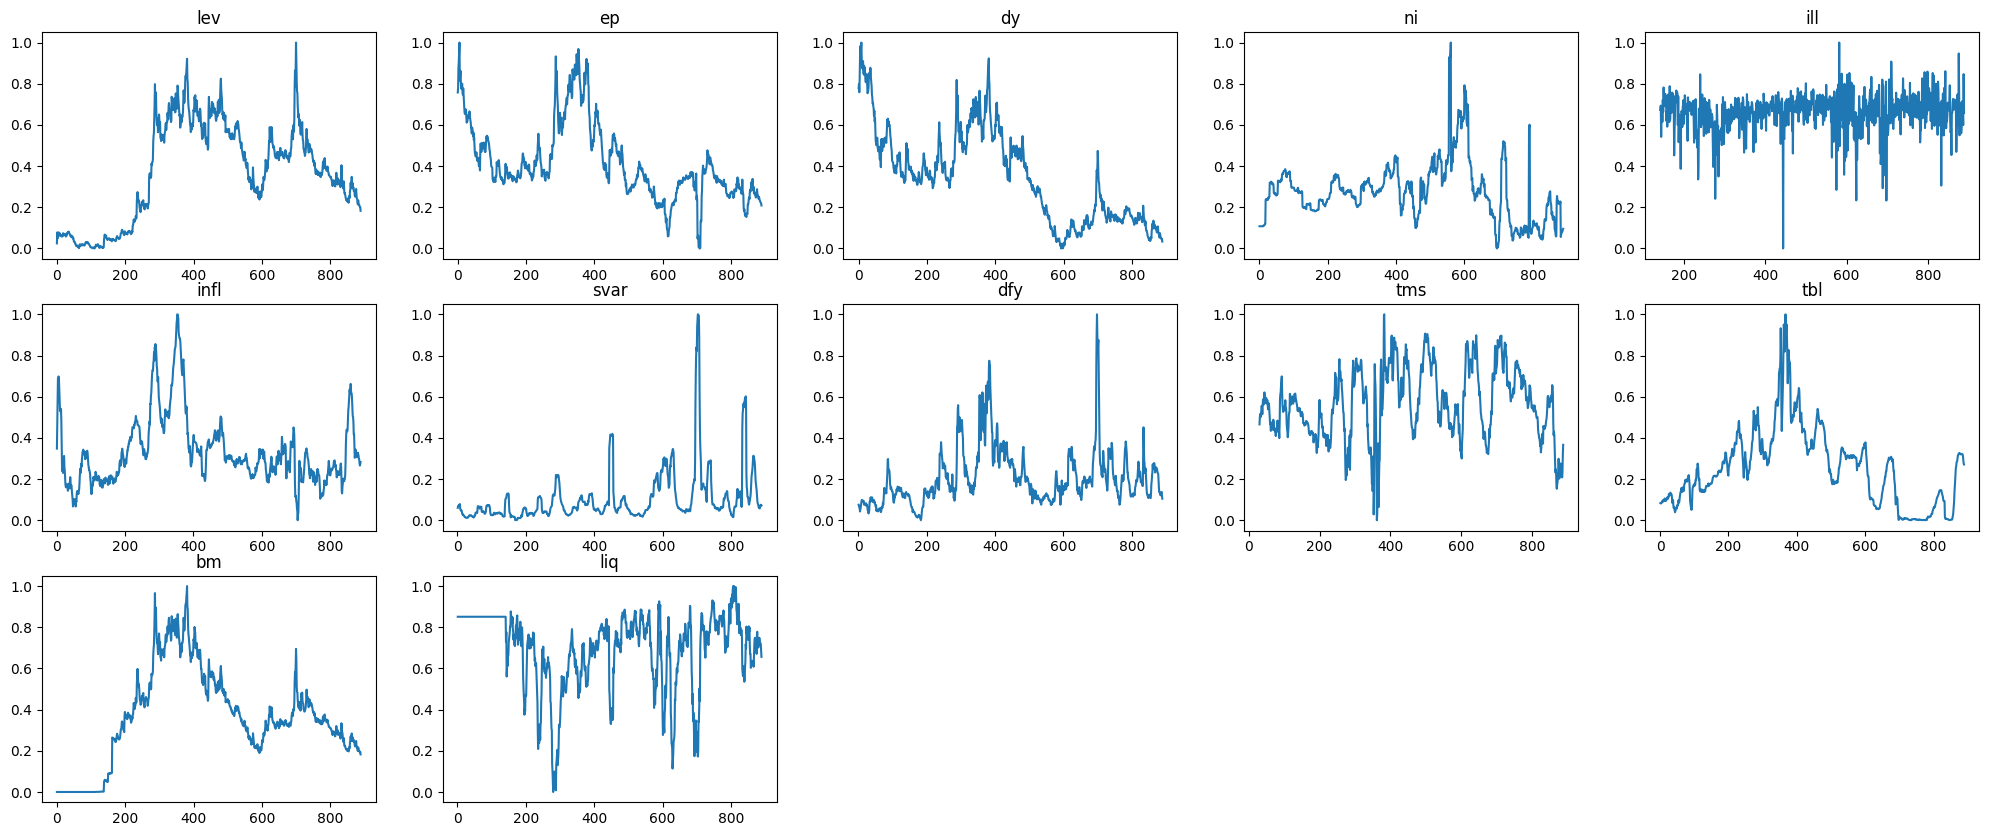

In [36]:
# Do Min-Max standardization
xt_minmax = df_xt.copy()
for xt in xt_list:
    xt_minmax[xt] = (xt_minmax[xt] - np.min(xt_minmax[xt])) / (np.max(xt_minmax[xt]) - np.min(xt_minmax[xt]))

xt_minmax.to_csv(f'xt_{end_month}_minmax.csv', index=False, encoding='utf_8_sig')

plt.figure(figsize=(25,10))
ax1 = plt.subplot(3,5,1);ax1.plot(xt_minmax['x_lev']);ax1.set_title('lev');
ax2 = plt.subplot(3,5,2);ax2.plot(xt_minmax['x_ep']);ax2.set_title('ep');
ax3 = plt.subplot(3,5,3);ax3.plot(xt_minmax['x_dy']);ax3.set_title('dy');
ax4 = plt.subplot(3,5,4);ax4.plot(xt_minmax['x_ni']);ax4.set_title('ni');
ax5 = plt.subplot(3,5,5);ax5.plot(xt_minmax['x_ill']);ax5.set_title('ill');
ax6 = plt.subplot(3,5,6);ax6.plot(xt_minmax['x_infl']);ax6.set_title('infl');
ax7 = plt.subplot(3,5,7);ax7.plot(xt_minmax['x_svar']);ax7.set_title('svar');
ax8 = plt.subplot(3,5,8);ax8.plot(xt_minmax['x_dfy']);ax8.set_title('dfy');
ax9 = plt.subplot(3,5,9);ax9.plot(xt_minmax['x_tms']);ax9.set_title('tms');
ax10=plt.subplot(3,5,10);ax10.plot(xt_minmax['x_tbl']);ax10.set_title('tbl');
ax11=plt.subplot(3,5,11);ax11.plot(xt_minmax['x_bm']);ax11.set_title('bm');
ax12=plt.subplot(3,5,12);ax12.plot(xt_minmax['x_liq']);ax12.set_title('liq');
plt.savefig("macro_raw_minmax.pdf",bbox_inches='tight')
plt.show()

### Rolling 10, 15, 20 Years Percentile Standardization

In [37]:
def quantile_standardize(x,w):
    '''
    x is a list
    w is the time window
    '''
    n = len(x)
    # print(n)
    y = []
    for i in range(n):
        if i>=w:
            h = x[:i][-w:]
            s = stats.rankdata(h, "average")/len(h)
            y.append(s[-1])
        elif i>=2:
            h = x[:i]
            s = stats.rankdata(h, "average")/len(h)
            y.append(s[-1])
        else:
            y.append(-2)
    return y  

100%|██████████| 13/13 [00:00<00:00, 18.43it/s]


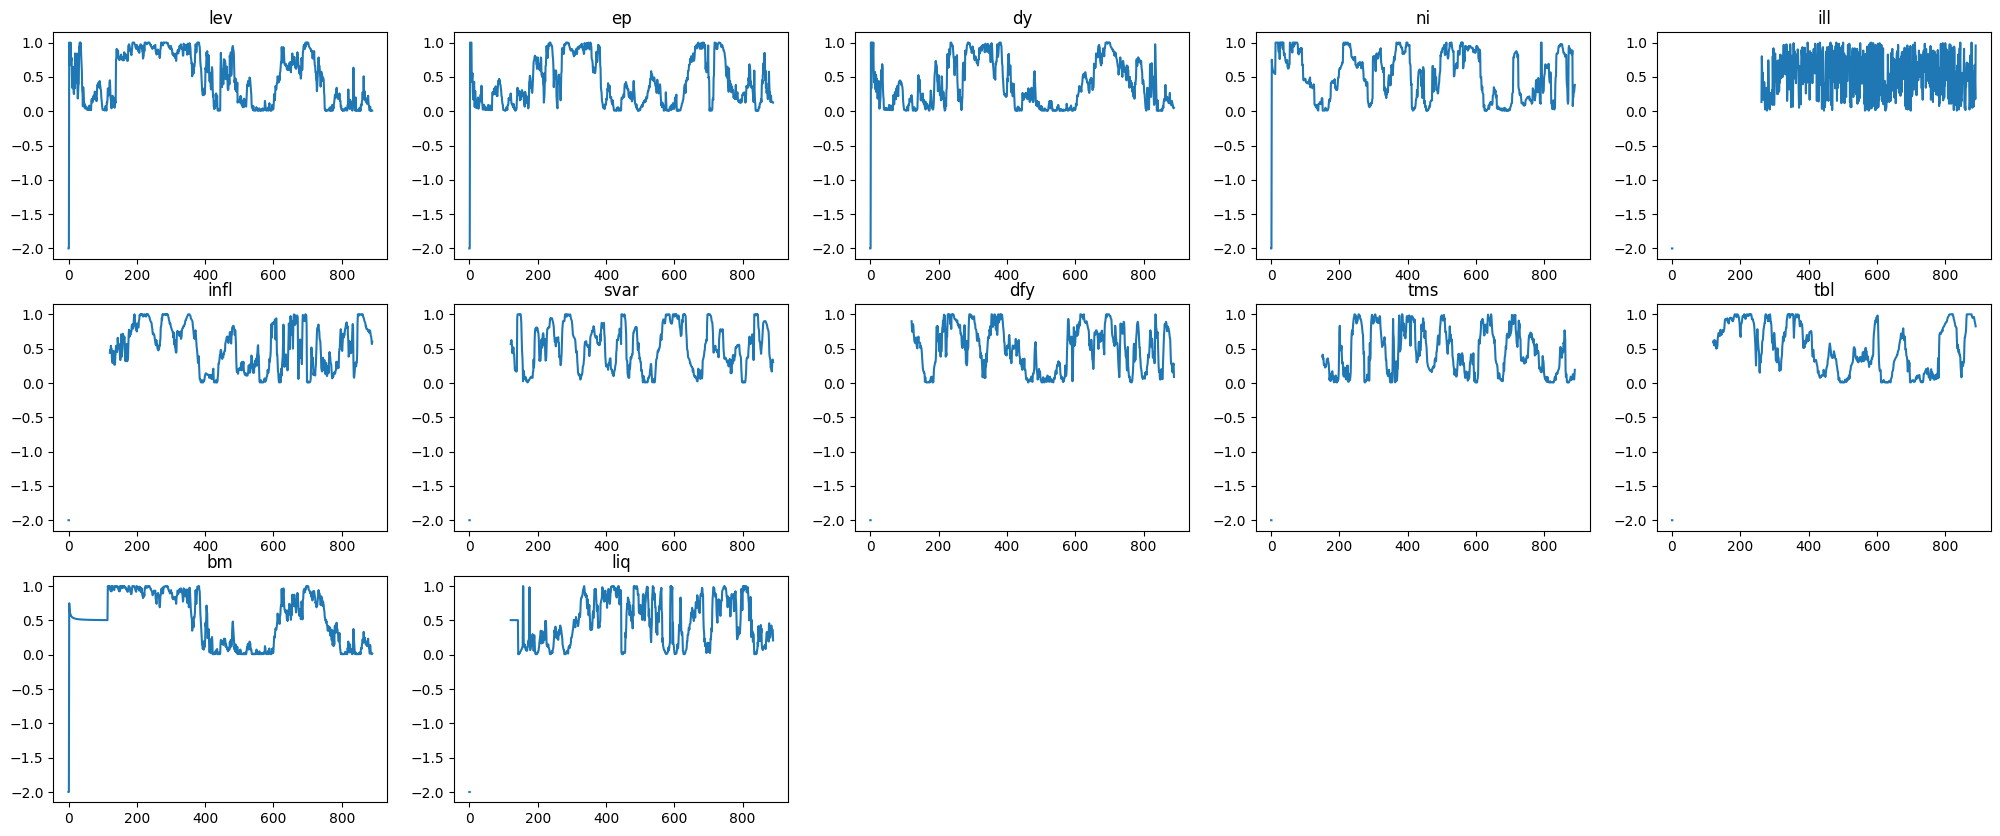

100%|██████████| 13/13 [00:00<00:00, 16.83it/s]


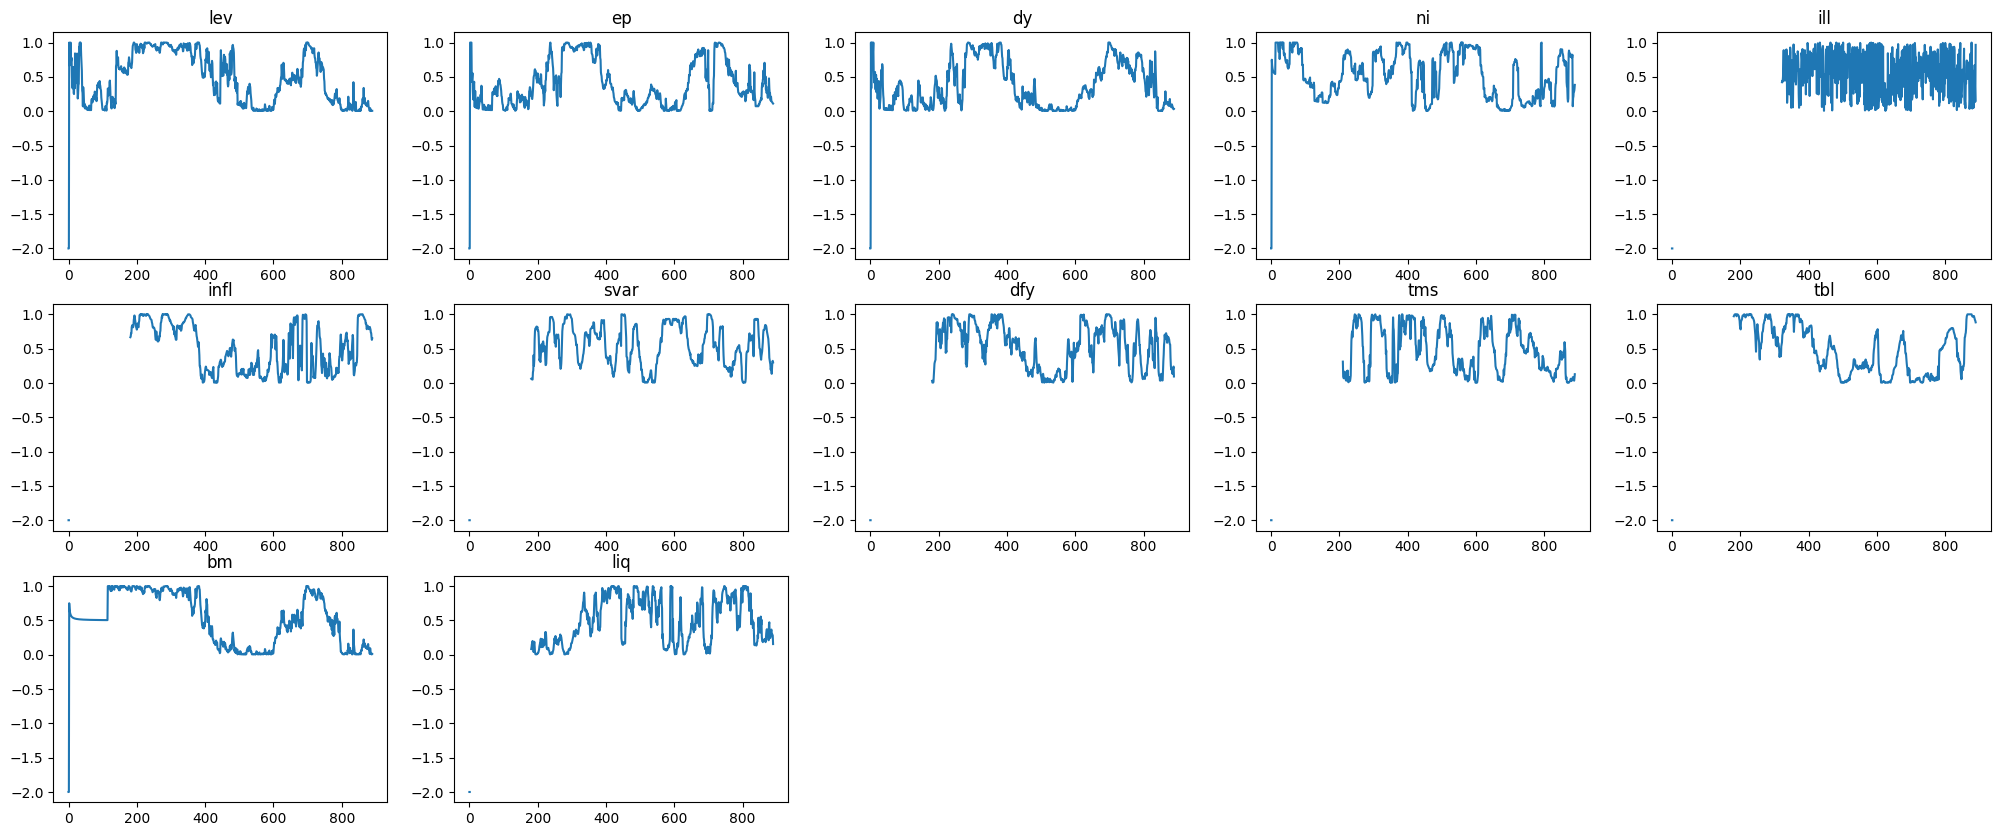

100%|██████████| 13/13 [00:00<00:00, 16.52it/s]


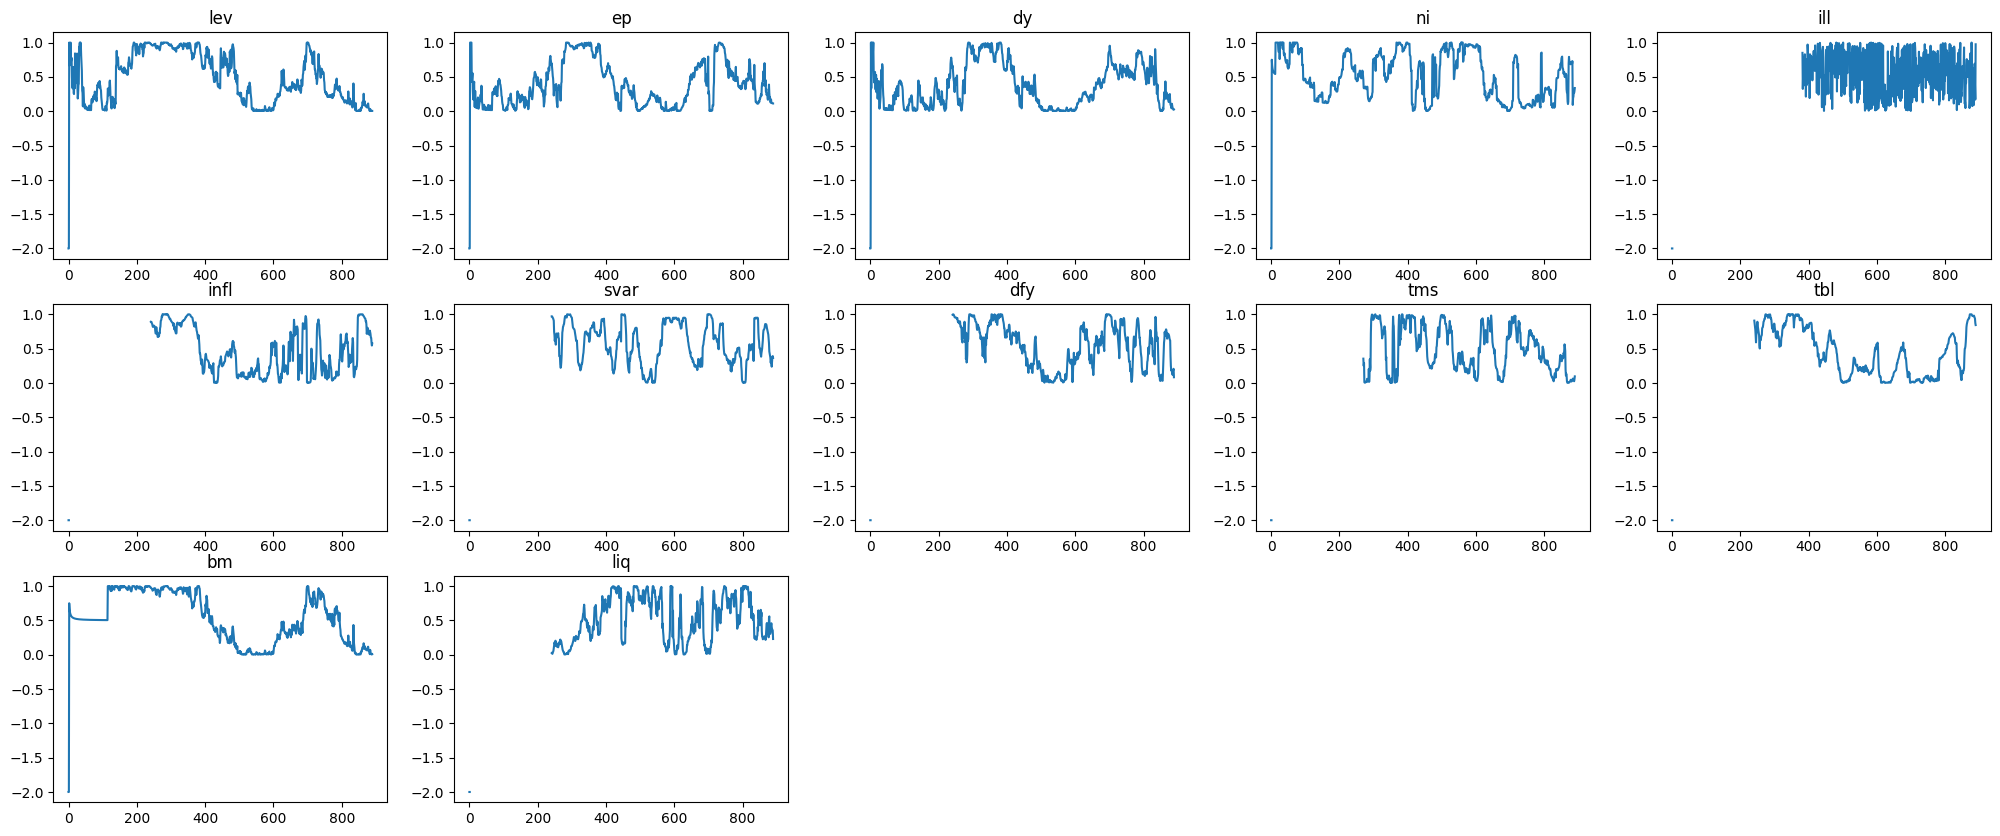

In [38]:
window_list = [10, 15, 20]
for window in window_list:
    xt_tmp = df_xt.copy()
    for vn in tqdm(xt_list):
        # print(vn)
        x = list(xt_tmp[vn].values)
        w = window * 12
        xt_tmp[vn] = quantile_standardize(x,w)
    xt_tmp['x_month'] = np.arange(1, xt_tmp.shape[0]+1)
    xt_tmp.to_csv(f'xt_{end_month}_{window}y.csv', index=False, encoding='utf_8_sig')

    plt.figure(figsize=(25,10))
    ax1 = plt.subplot(3,5,1);ax1.plot(xt_tmp['x_lev']);ax1.set_title('lev');
    ax2 = plt.subplot(3,5,2);ax2.plot(xt_tmp['x_ep']);ax2.set_title('ep');
    ax3 = plt.subplot(3,5,3);ax3.plot(xt_tmp['x_dy']);ax3.set_title('dy');
    ax4 = plt.subplot(3,5,4);ax4.plot(xt_tmp['x_ni']);ax4.set_title('ni');
    ax5 = plt.subplot(3,5,5);ax5.plot(xt_tmp['x_ill']);ax5.set_title('ill');
    ax6 = plt.subplot(3,5,6);ax6.plot(xt_tmp['x_infl']);ax6.set_title('infl');
    ax7 = plt.subplot(3,5,7);ax7.plot(xt_tmp['x_svar']);ax7.set_title('svar');
    ax8 = plt.subplot(3,5,8);ax8.plot(xt_tmp['x_dfy']);ax8.set_title('dfy');
    ax9 = plt.subplot(3,5,9);ax9.plot(xt_tmp['x_tms']);ax9.set_title('tms');
    ax10=plt.subplot(3,5,10);ax10.plot(xt_tmp['x_tbl']);ax10.set_title('tbl');
    ax11=plt.subplot(3,5,11);ax11.plot(xt_tmp['x_bm']);ax11.set_title('bm');
    ax12=plt.subplot(3,5,12);ax12.plot(xt_tmp['x_liq']);ax12.set_title('liq');
    plt.savefig(f"macro_raw_{window}y.pdf",bbox_inches='tight')
    plt.show()
    plt.close()

##### Demean and simple smooth

In [39]:
df_demean = df_xt.copy()
df_demean = df_demean.set_index('date')
df_demean = df_demean - df_demean.rolling(120,min_periods=36).mean()

window_size = 12

x = np.arange(window_size)+1
weights = x/np.sum(x)

usmkt_demean_simple = df_demean.copy()
for col in df_demean.columns:
    usmkt_demean_simple[col] = usmkt_demean_simple[col].rolling(12).apply(lambda x: np.average(x, weights=weights))
usmkt_demean_simple = usmkt_demean_simple.reset_index()
usmkt_demean_simple.to_csv(f'xt_{end_month}_demean_simple_smooth.csv', index=False, encoding='utf_8_sig')